## Input

Input files:

In [1]:
# input data
outdir     = "results_hap_analysis"
metasam_fn = "metadata/samples.meta_phenotypes.txt"
accessi_fn = "/home/xavi/dades/Variation/phase2.AR1/accessibility/accessibility.h5"
haploty_fn = "/home/xavi/dades/Variation/phase2.AR1/haplotypes/zarr2/ag1000g.phase2.ar1.samples/"

In [2]:
# define populations
outcode    = "out"
popl       = ["AOcol","BFcol","BFgam","CIcol","CMgam","FRgam","GAgam","GHcol","GHgam","GM","GNcol","GNgam","GQgam","GW","KE","UGgam"]
popc       = "population"
chrom      = "2R"
l_nom      = "Ace1"

# exclude these samples
excludec   = "ox_code"
excludel   = ["NO RES"]
# traits to subset
sub1c      = "population"
sub1l      = ["AOcol","BFcol","BFgam","CIcol","CMgam","FRgam","GAgam","GHcol","GHgam","GM","GNcol","GNgam","GQgam","GW","KE","UGgam"]

# gene coordinates
ace_start = 3489213
ace_end   = 3493788
ace_119S  = 3492074

# duplication coordinates
ace_dups  = 3436800 # start duplication
ace_dupe  = 3639600 # end duplication

# flanking bp or num haps, to retain in analysis
fbp_var    = 1e4     # num bp to retain around loci of interest (duplication)

In [3]:
import numpy as np
import zarr
import pandas as pd
import allel
import h5py
import warnings
import scipy
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import itertools
from mlxtend.evaluate import permutation_test
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage

warnings.simplefilter('ignore')

%run scripts_hapclust/hapclust.py
%run scripts_printtranscripts/allel_printtranscripts_24gen18.py

In [4]:
# colors populations only
pop_colors = { 
 'AOcol' : "slategray",
 'BFcol' : "purple",
 'BFgam' : "blue",
 'CIcol' : "orange",
 'CMgam' : "lightgray",
 'FRgam' : "lightgray",
 'GAgam' : "lightgray",
 'GHcol' : "violet",
 'GHgam' : "dodgerblue",
 'GM'    : "gray",
 'GNcol' : "slategray",
 'GNgam' : "cyan",
 'GQgam' : "lightgray",
 'GW'    : "gray",
 'KE'    : "gray",
 'UGgam' : "lightgray"
}

# convert dict to array
popl_col = [pop_colors[popi] for popi in popl]

# variant colors
var_colors = dict({
    0 : "lightgray",
    1 : "deepskyblue"
})

In [5]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx,array[idx]
        
def identify_components(h_distinct_sets, components):
    """This function is designed to collect all indices for original haplotypes 
    within each connected component. I.e., it finds clusters from the network."""
    clusters = []
    for c in np.unique(components):
        cluster = set()
        for i in np.nonzero(components == c)[0]:
            cluster |= h_distinct_sets[i]
        clusters.append(sorted(cluster))
    return clusters


# load plot settings
sns.set(context="notebook",style="ticks",
        font_scale=1,font="Arial",palette="bright")

## Load data

### Load genotypes

In [6]:
# LOAD DATA
print("Samples bool...")
# load samples list with sample code, groupings, locations etc.
samples_df   = pd.read_csv(metasam_fn, sep='\t')
samples_bool = (
    samples_df[popc].isin(popl).values & 
    samples_df[sub1c].isin(sub1l).values &
    ~samples_df[excludec].isin(excludel).values)
samples_sub  = samples_df[samples_bool]
samples_sub.reset_index(drop=True, inplace=True)


print("Samples dictionary...")
# indexed dictionary of populations
popdict = dict()
for popi in popl: 
    popdict[popi]  = samples_sub[samples_sub[popc] == popi].index.tolist()

# add an extra population composed of all other locations
popdict["all"] = []
for popi in popl:
    popdict["all"] = popdict["all"] + popdict[popi]

gen_pops_count = samples_sub.groupby(popc).size()
gen_pops_count

Samples bool...
Samples dictionary...


population
AOcol     78
BFcol     75
BFgam     92
CIcol     71
CMgam    297
FRgam     24
GAgam     69
GHcol     55
GHgam     12
GM        65
GNcol      4
GNgam     40
GQgam      9
GW        91
KE        48
UGgam    112
dtype: int64

### Load haplotypes

In [7]:
# haplotypes: variants
hapcall     = zarr.open(haploty_fn)
print("Load haplotype variants...")
hapcall_var = hapcall[chrom]["variants"]
hapvars     = allel.VariantChunkedTable(hapcall_var,names=["POS","REF","ALT"],index="POS")

# haplotypes: phased genotypes
print("Load haplotype haplotypes...")
hapcall_gen = hapcall[chrom]["calldata/genotype"]
haploty_gen = allel.GenotypeChunkedArray(hapcall_gen)
# find samples in haplotype dataset that coincide with genotypes
haploty_sam = hapcall[chrom]["samples"][:].astype(str)
hapsam_bool = np.isin(haploty_sam, np.array(samples_sub["ox_code"]))
haploty_gen = haploty_gen.subset(sel1=hapsam_bool)
print(haploty_gen.shape)

# recast haplotypes: drop ploidy
print("Drop ploidy haplotypes...")
haploty_hap = haploty_gen.to_haplotypes()
print(haploty_hap.shape)

Load haplotype variants...
Load haplotype haplotypes...
(12047846, 1142, 2)
Drop ploidy haplotypes...
(12047846, 2284)


In [8]:
# haplotype dicts
# arrays of hap ids and populations of each hap (double the size of genotype arryays: 2 haps per individual except in X chromosome)
print("Samples dictionary for haps...")
is_samp_in_hap = np.isin(np.array(samples_sub["ox_code"]),haploty_sam)
hap_ids        = np.array(list(itertools.chain(*[[s + ' a', s + ' b'] for s in haploty_sam[hapsam_bool]])))
hap_pops       = np.array(list(itertools.chain(*[[s, s] for s in np.array(samples_sub[popc][is_samp_in_hap])])))
hap_pops_count = pd.DataFrame(data={ popc : np.unique(hap_pops,return_counts=True)[0], "counts" : np.unique(hap_pops,return_counts=True)[1] }).set_index(popc)
hap_pops_df    = pd.DataFrame(data={ popc : hap_pops})

# pop dicts for haplotype data
popdicthap = dict()
for popi in popl: 
    popdicthap[popi]  = hap_pops_df[hap_pops_df[popc] == popi].index.tolist()

popdicthap["all"] = []
for popi in popl:
    popdicthap["all"] = popdicthap["all"] + popdicthap[popi]

hap_pops_count = hap_pops_df.groupby(popc).size()
hap_pops_count

Samples dictionary for haps...


population
AOcol    156
BFcol    150
BFgam    184
CIcol    142
CMgam    594
FRgam     48
GAgam    138
GHcol    110
GHgam     24
GM       130
GNcol      8
GNgam     80
GQgam     18
GW       182
KE        96
UGgam    224
dtype: int64

In [9]:
# haplotypes: allele counts
print("Allele counts haplotypes...")
hapalco_hap = haploty_hap.count_alleles_subpops(subpops=popdicthap)
print(hapalco_hap.shape)

Allele counts haplotypes...
(12047846,)


Subset:

In [10]:
# filter haplotypes: segregating alleles, no singletons
is_hapseg    = hapalco_hap["all"].is_segregating()     # segregating
is_hapnosing = hapalco_hap["all"][:,:2].min(axis=1)>2  # no singletons
filhap_bool  = (is_hapseg & is_hapnosing)

# subset
print("Apply filters haps...")
haploty_seg = haploty_hap.compress(filhap_bool)
hapvars_seg = hapvars.compress(filhap_bool)
hapalco_seg = hapalco_hap.compress(filhap_bool)
print(haploty_seg.shape)
print(hapalco_seg.shape)

# reformat hap arrays as dask (for network function)
print("Dask hapa...")
loci_pos     = allel.SortedIndex(hapcall_var['POS'])
haploty_dask = allel.GenotypeDaskArray(hapcall_gen)
haploty_dask = haploty_dask.subset(sel1=hapsam_bool)
haploty_haps = haploty_dask.to_haplotypes()
print(haploty_haps.shape)

Apply filters haps...
(6799278, 2284)
(6799278,)
Dask hapa...
(12047846, 2284)


### Load other

In [11]:
# Accessibility
print("Load accessibility array...")
accessi_df  = h5py.File(accessi_fn,mode="r")
accessi_arr = accessi_df[chrom]["is_accessible"][:]

Load accessibility array...


## Variants linked to `280S`

Linked variants:

In [12]:
genilist = [3465693,3469441,3481632,3504796]
geniname = ["tag1","tag2","tag3","tag4"]
genilist, geniname

([3465693, 3469441, 3481632, 3504796], ['tag1', 'tag2', 'tag3', 'tag4'])

## Haplotype networks

Compute haplotype networks for variants that are in LD with `119S`.

**** tag1 allele 2R 3465693 3465693 482523 ****


total haps: 2284


**** tag2 allele 2R 3469441 3469441 482768 ****


total haps: 2284


**** tag3 allele 2R 3481632 3481632 483275 ****


total haps: 2284


**** tag4 allele 2R 3504796 3504796 483676 ****


total haps: 2284


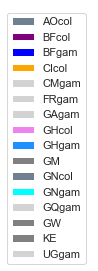

In [13]:
fbp_hap  = 300     # num bp to retain around variant of interest (allele) to define core haplotyes, CC uses 6kbp
max_dist = 1       # dist that breaks edges; default is 5; CC uses 2 -> if network method is MJN, then it doesn't work for max_dist>1!!!!
net_meth = "mst"   # can be: minimum_spanning_network msn ; minimum_spanning_tree mst ; median_joining_network mjt
geni_components_id_dati = dict()

for h,geni in enumerate(genilist):
    
    geni_bool    = hapvars_seg["POS"] == geni
    loci_loc     = loci_pos.locate_range(geni-fbp_hap,geni+fbp_hap)      
    loci_hhh     = haploty_haps[loci_loc]

    # plot haplotype net for indivioduals with haplotypes
    hap_ix,hap_pos = find_nearest(hapvars_seg["POS"][:],geni)
    print("****",geniname[h],"allele",chrom,geni,hap_pos,hap_ix,"****")

    geni_dkey  = str(hap_pos)
    geni_pos   = haploty_haps[loci_pos.locate_key(hap_pos)] >= 0
    geni_hapid = hap_ids[geni_pos]
    geni_pops  = hap_pops[geni_pos]
    geni_popc  = np.array([pop_colors[p] for p in geni_pops])
    geni_hhh   = loci_hhh.compress(geni_pos, axis=1)
    geni_gra, geni_distinct_sets, geni_components = graph_haplotype_network(
        h=geni_hhh,
        max_dist=max_dist,   
        max_allele=3, # for MJN only; default is 3
        show_node_labels=1,
        distance_metric='hamming',network_method=net_meth,
        hap_colors=geni_popc,
        return_components=True,
        show_singletons=True)

    num_components = geni_components.shape[0]

    # plot pdf
    geni_gra.format = 'pdf'
    geni_gra.attr(label='\n\n%s %s %s:%i, allele %s\n%i haps clustered into %i clusters with %s maxdist %i, from %i phased vars located +/- %i bp' % (l_nom,geniname[h],chrom,geni,hap_pos,geni_hhh.shape[1],num_components,net_meth,max_dist,geni_hhh.shape[0],fbp_hap))
    fn = "%s/%s_%s.Hapnet_%s_var_%s-pop" % (outdir,outcode,l_nom,net_meth,geni)
    geni_gra.render(fn,cleanup=True)

    # map hap clusters with REF alleles to actual lists of populations
    # BEWARE: identify_components fails if max_dist > 1 in MJN
    geni_components_id      = identify_components(geni_distinct_sets, geni_components) 
    geni_components_id_hapi = []
    geni_components_id_clui = []
    geni_components_id_dati[geni_dkey] = pd.DataFrame()
    for n,i in enumerate(geni_components_id):
        geni_components_id_hapi = geni_components_id_hapi + geni_components_id[n]
        geni_components_id_clui = geni_components_id_clui + list([n]*len(geni_components_id[n]))

    geni_components_id_dati[geni_dkey]["hap_index"]    = geni_components_id_hapi
    geni_components_id_dati[geni_dkey]["hap_cluster"]  = geni_components_id_clui
    geni_components_id_dati[geni_dkey]                 = geni_components_id_dati[geni_dkey].sort_values(by="hap_index")
    geni_components_id_dati[geni_dkey]                 = geni_components_id_dati[geni_dkey].set_index(keys="hap_index")
    geni_components_id_dati[geni_dkey]["pop"]          = geni_pops[geni_components_id_dati[geni_dkey].index]
    geni_components_id_dati[geni_dkey]["hap_id"]       = geni_hapid[geni_components_id_dati[geni_dkey].index]
    geni_components_id_dati[geni_dkey]["hap_distinct"] = None

    for jx in range(len(geni_distinct_sets)):
        jxl = list(geni_distinct_sets[jx])
        geni_components_id_dati[geni_dkey]["hap_distinct"][jxl] = jx

    # report
    print("total haps:",geni_hhh.shape[1])

    # for plots with REF and ALT alleles, plot additional network that colors
    # clusters according to which allele they carry (variant of interest)
    geni_popc = np.asarray(haploty_haps[loci_pos.locate_key(hap_pos)])
    geni_popc2  = np.array([var_colors[p] for p in geni_popc])
    geni_gra, geni_distinct_sets, geni_components = graph_haplotype_network(
        h=geni_hhh,
        max_dist=max_dist,   
        max_allele=3, # for MJN only; default is 3
        show_node_labels=1,
        distance_metric='hamming',network_method=net_meth,
        hap_colors=geni_popc2,
        return_components=True,
        show_singletons=True)

    # plot pdf
    geni_gra.format = 'pdf'
    geni_gra.attr(label='\n\n%s %s %s:%i, allele %s\n%i haps clustered with %s, maxdist %i from %i phased vars located +/- %i bp' % (l_nom,geniname[h],chrom,geni,hap_pos,geni_hhh.shape[1],net_meth,max_dist,geni_hhh.shape[0],fbp_hap))
    fn = "%s/%s_%s.Hapnet_%s_var_%s-v01" % (outdir,outcode,l_nom,net_meth,geni)
    geni_gra.render(fn,cleanup=True)

    # save table
    geni_components_id_dati[geni_dkey]["allele"] = geni_popc
    geni_components_id_dati[geni_dkey].to_csv("%s/%s_%s.Hapnet_%s_var_%s.csv" % (outdir,outcode,l_nom,net_meth,geni),sep="\t",index=False)

            
# plot color legend
# WARNING: colors might be slightly different because matplotlib and graphviz parse them differently
pdf = PdfPages("%s/%s_%s.Hapnet_legend.pdf" % (outdir,outcode,l_nom))
fig,ax = plt.subplots(figsize=(1,1))
ax.set_axis_off()
custom_lines = [mpatches.Patch(facecolor=pop_colors[coli]) for coli in popl]
plt.legend(labels=popl,handles=custom_lines)
pdf.savefig(fig,bbox_inches='tight')
pdf.close()

## EHH decay

Plot EHH decay around the variants and genes of interest, treating ref and alt alleles separately.

In [14]:
flank_hap     = 1e5   # num haplotypes to retain for EHH calculations
ehh_above_thr = 0.95
ehh_below_thr = 0.05

First, around variants of interest:

**** tag1 3465693 | EHH for clusters in alleles ref and alt
**** tag2 3469441 | EHH for clusters in alleles ref and alt
**** tag3 3481632 | EHH for clusters in alleles ref and alt
**** tag4 3504796 | EHH for clusters in alleles ref and alt


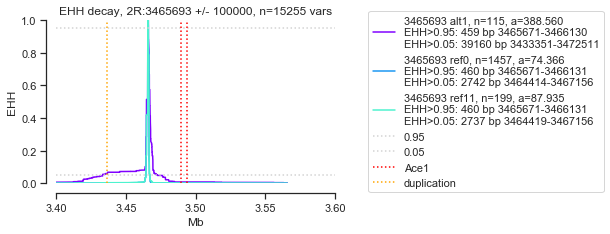

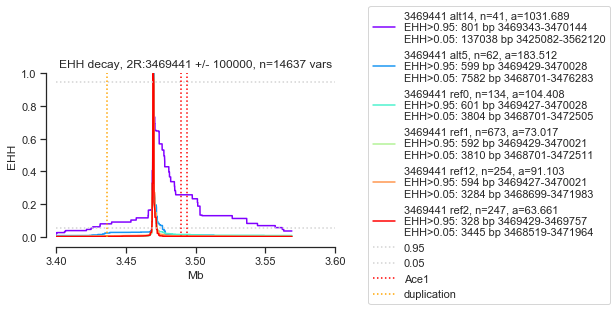

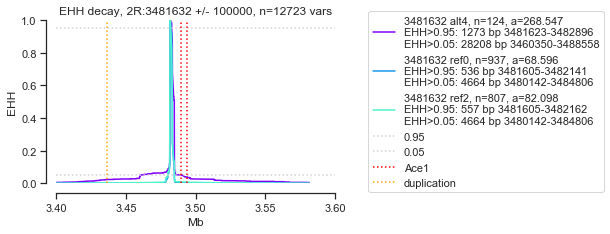

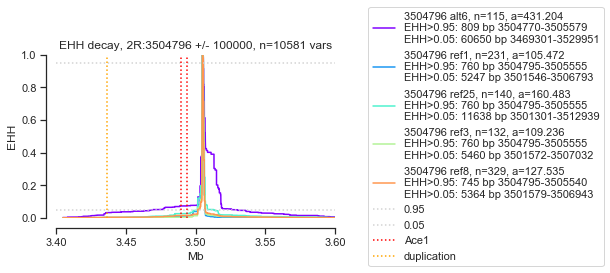

In [15]:
colors = cm.rainbow(np.linspace(0, 1, 6))

pdf = PdfPages("%s/%s_%s.EHHdecay_varshap.pdf" % (outdir,outcode,l_nom))

for h,geni in enumerate(genilist):
    
    geni_bool = hapvars_seg["POS"][:] == geni
    geni_dkey = str(geni)

    # open new fig, one per tagging variant
    fig = plt.figure(figsize=(5,3))
    ax3 = plt.subplot(1, 1, 1)

    # create hap dictionary: similar to pop dict, but for associations hap-cluster
    popdicthap_clui = dict()
    # first, for alternate allele clusters:
    is_clu_alt   = geni_components_id_dati[geni_dkey]["allele"] == 1
    is_clu_large_clust = np.unique(geni_components_id_dati[geni_dkey]["hap_distinct"][is_clu_alt],return_counts=True)[0]
    is_clu_large_sizes = np.unique(geni_components_id_dati[geni_dkey]["hap_distinct"][is_clu_alt],return_counts=True)[1]
    for i,clvi in enumerate(is_clu_large_clust):
        if is_clu_large_sizes[i] > 20 :
            is_clu_large = geni_components_id_dati[geni_dkey]["hap_distinct"] == clvi
            popdicthap_clui["alt" + str(clvi)] = np.where(np.logical_and(is_clu_alt, is_clu_large))[0]
    # then, for reference allele clusters
    is_clu_ref = geni_components_id_dati[geni_dkey]["allele"] == 0
    is_clu_large_clust = np.unique(geni_components_id_dati[geni_dkey]["hap_distinct"][is_clu_ref],return_counts=True)[0]
    is_clu_large_sizes = np.unique(geni_components_id_dati[geni_dkey]["hap_distinct"][is_clu_ref],return_counts=True)[1]
    for i,clvi in enumerate(is_clu_large_clust):
        if is_clu_large_sizes[i] > 100 :
            is_clu_large = geni_components_id_dati[geni_dkey]["hap_distinct"] == clvi
            popdicthap_clui["ref" + str(clvi)] = np.where(np.logical_and(is_clu_ref, is_clu_large))[0]

    # report
    print("****",geniname[h],geni,"| EHH for clusters in alleles ref and alt")

    # find phased variant
    hap_ix,hap_pos = find_nearest(hapvars_seg["POS"][:],geni)

    # select variants to include (depends on tagging variant)
    clu_varbool_up = np.logical_and(hapvars_seg["POS"] >= geni-flank_hap, hapvars_seg["POS"] < geni)
    clu_varbool_do = np.logical_and(hapvars_seg["POS"] > geni, hapvars_seg["POS"] <= geni+flank_hap)
    clu_varbool    = np.logical_or(clu_varbool_up,clu_varbool_do)

    # array of positions for EHH plot
    clu_ehh_pos = hapvars_seg["POS"].subset(sel0=clu_varbool)

    sorted_keys = sorted(popdicthap_clui.keys(), key=lambda x:x.lower())
    for i,clui in enumerate(sorted_keys):

        # select samples to include (depends on tagging variant, and on genotype ref/alt)
        clu_sambool = np.isin(range(0,haploty_seg.n_haplotypes),test_elements=popdicthap_clui[clui])

        # calculate EHH
        clu_ehh_up_i = allel.ehh_decay(h=haploty_seg.subset(sel0=clu_varbool_up,sel1=clu_sambool))
        clu_ehh_do_i = allel.ehh_decay(h=haploty_seg.subset(sel0=clu_varbool_do,sel1=clu_sambool))
        clu_ehh_i    = np.concatenate((clu_ehh_up_i[::-1],clu_ehh_do_i))
        clu_ehh_i_ar = np.trapz(clu_ehh_i)
        ehh_above_start = clu_ehh_pos.compress(clu_ehh_i > ehh_above_thr)[0]
        ehh_above_end   = clu_ehh_pos.compress(clu_ehh_i > ehh_above_thr)[-1]
        ehh_below_start = clu_ehh_pos.compress(clu_ehh_i > ehh_below_thr)[0]
        ehh_below_end   = clu_ehh_pos.compress(clu_ehh_i > ehh_below_thr)[-1]

        # lab is data
        clu_lab    = "%s %s, n=%i, a=%.3f\nEHH>%.2f: %i bp %i-%i\nEHH>%.2f: %i bp %i-%i" % (
            geni, clui, len(popdicthap_clui[clui]),clu_ehh_i_ar, 
            ehh_above_thr, ehh_above_end-ehh_above_start, ehh_above_start, ehh_above_end,
            ehh_below_thr, ehh_below_end-ehh_below_start, ehh_below_start, ehh_below_end
        )

        # plot EHH background & foreground
        ax3.plot(clu_ehh_pos/1e6,clu_ehh_i,color=colors[i],label=clu_lab,mfc='none')

    sns.despine(ax=ax3,offset=10)
    ax3.set_title("EHH decay, %s:%i +/- %i, n=%s vars" % (chrom,geni,flank_hap,clu_ehh_pos.shape[0]))
    ax3.set_xlabel("Mb")
    ax3.set_ylabel("EHH")
    #ax3.set_xlim((ace_dups-25000)/1e6,(ace_dupe+25000)/1e6)
    ax3.set_xlim(3.4,3.6)
    ax3.set_ylim(0,1)
    plt.axhline(ehh_above_thr, color='lightgray',linestyle=":",label=str(ehh_above_thr))
    plt.axhline(ehh_below_thr, color='lightgray',linestyle=":",label=str(ehh_below_thr))
    plt.axvline(ace_start/1e6, color='red',linestyle=":",label="Ace1")
    plt.axvline(ace_end/1e6, color='red',linestyle=":",label="")
    plt.axvline(ace_dups/1e6, color='orange',linestyle=":",label="duplication")
    plt.axvline(ace_dupe/1e6, color='orange',linestyle=":",label="")
    ax3.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

    pdf.savefig(fig,bbox_inches='tight')
        
pdf.close()

Now, using the haplotype clusters of the tagging variants, let's look at the EHH at the 5' and 3' ends of the duplication:

**** tag1 3465693 3436800 | EHH for clusters in alleles ref and alt
**** tag1 3465693 3639600 | EHH for clusters in alleles ref and alt
**** tag2 3469441 3436800 | EHH for clusters in alleles ref and alt
**** tag2 3469441 3639600 | EHH for clusters in alleles ref and alt
**** tag3 3481632 3436800 | EHH for clusters in alleles ref and alt
**** tag3 3481632 3639600 | EHH for clusters in alleles ref and alt
**** tag4 3504796 3436800 | EHH for clusters in alleles ref and alt
**** tag4 3504796 3639600 | EHH for clusters in alleles ref and alt


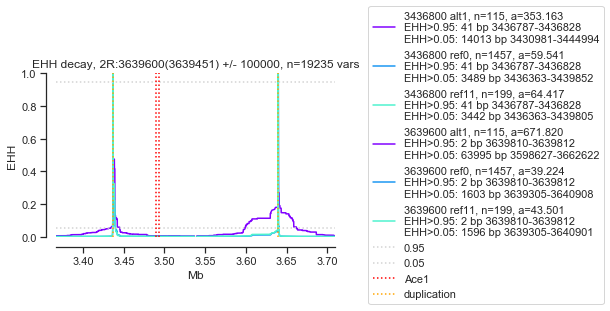

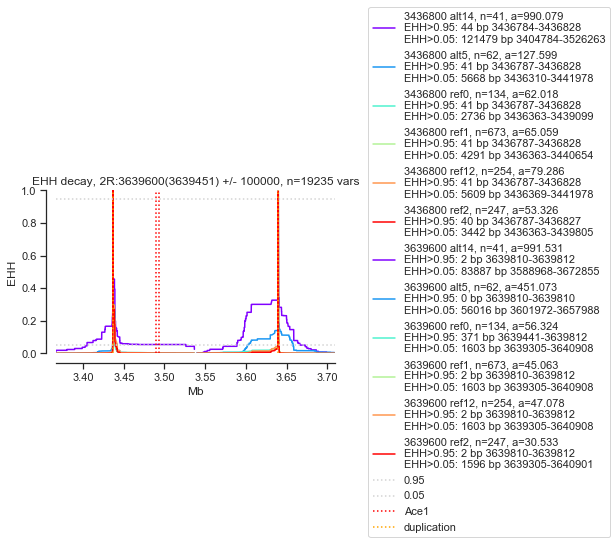

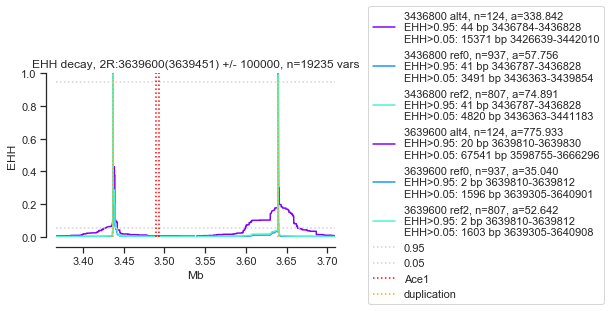

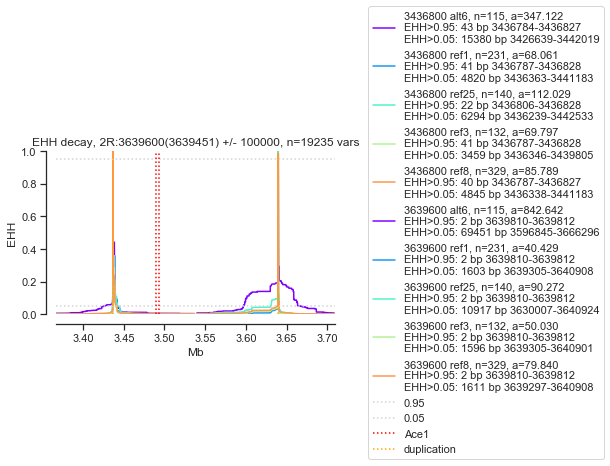

In [16]:
colors = cm.rainbow(np.linspace(0, 1, 6))

pdf = PdfPages("%s/%s_%s.EHHdecay_dupendshap.pdf" % (outdir,outcode,l_nom))

for h,geni in enumerate(genilist):
    
    geni_bool = hapvars_seg["POS"][:] == geni
    geni_dkey = str(geni)

    # open new fig, one per tagging variant
    fig = plt.figure(figsize=(5,3))
    ax3 = plt.subplot(1, 1, 1)

    # create hap dictionary: similar to pop dict, but for associations hap-cluster
    popdicthap_clui = dict()
    # first, for alternate allele clusters:
    is_clu_alt   = geni_components_id_dati[geni_dkey]["allele"] == 1
    is_clu_large_clust = np.unique(geni_components_id_dati[geni_dkey]["hap_distinct"][is_clu_alt],return_counts=True)[0]
    is_clu_large_sizes = np.unique(geni_components_id_dati[geni_dkey]["hap_distinct"][is_clu_alt],return_counts=True)[1]
    for i,clvi in enumerate(is_clu_large_clust):
        if is_clu_large_sizes[i] > 20 :
            is_clu_large = geni_components_id_dati[geni_dkey]["hap_distinct"] == clvi
            popdicthap_clui["alt" + str(clvi)] = np.where(np.logical_and(is_clu_alt, is_clu_large))[0]
    # then, for reference allele clusters
    is_clu_ref = geni_components_id_dati[geni_dkey]["allele"] == 0
    is_clu_large_clust = np.unique(geni_components_id_dati[geni_dkey]["hap_distinct"][is_clu_ref],return_counts=True)[0]
    is_clu_large_sizes = np.unique(geni_components_id_dati[geni_dkey]["hap_distinct"][is_clu_ref],return_counts=True)[1]
    for i,clvi in enumerate(is_clu_large_clust):
        if is_clu_large_sizes[i] > 100 :
            is_clu_large = geni_components_id_dati[geni_dkey]["hap_distinct"] == clvi
            popdicthap_clui["ref" + str(clvi)] = np.where(np.logical_and(is_clu_ref, is_clu_large))[0]

     
    for j,dupi in enumerate([ace_dups,ace_dupe]):
        
        # report
        print("****",geniname[h],geni,dupi,"| EHH for clusters in alleles ref and alt")

        # find phased variant
        hap_ix,hap_pos = find_nearest(hapvars_seg["POS"][:],dupi)

        # select variants to include (depends on tagging variant)
        clu_varbool_up = np.logical_and(hapvars_seg["POS"] >= hap_pos-flank_hap, hapvars_seg["POS"] < hap_pos)
        clu_varbool_do = np.logical_and(hapvars_seg["POS"] > hap_pos, hapvars_seg["POS"] <= hap_pos+flank_hap)
        clu_varbool    = np.logical_or(clu_varbool_up,clu_varbool_do)

        # array of positions for EHH plot
        clu_ehh_pos = hapvars_seg["POS"].subset(sel0=clu_varbool)

        sorted_keys = sorted(popdicthap_clui.keys(), key=lambda x:x.lower())
        for i,clui in enumerate(sorted_keys):

            # select samples to include (depends on tagging variant, and on genotype ref/alt)
            clu_sambool = np.isin(range(0,haploty_seg.n_haplotypes),test_elements=popdicthap_clui[clui])

            # calculate EHH
            clu_ehh_up_i = allel.ehh_decay(h=haploty_seg.subset(sel0=clu_varbool_up,sel1=clu_sambool))
            clu_ehh_do_i = allel.ehh_decay(h=haploty_seg.subset(sel0=clu_varbool_do,sel1=clu_sambool))
            clu_ehh_i    = np.concatenate((clu_ehh_up_i[::-1],clu_ehh_do_i))
            clu_ehh_i_ar = np.trapz(clu_ehh_i)
            ehh_above_start = clu_ehh_pos.compress(clu_ehh_i > ehh_above_thr)[0]
            ehh_above_end   = clu_ehh_pos.compress(clu_ehh_i > ehh_above_thr)[-1]
            ehh_below_start = clu_ehh_pos.compress(clu_ehh_i > ehh_below_thr)[0]
            ehh_below_end   = clu_ehh_pos.compress(clu_ehh_i > ehh_below_thr)[-1]

            # lab is data
            clu_lab    = "%s %s, n=%i, a=%.3f\nEHH>%.2f: %i bp %i-%i\nEHH>%.2f: %i bp %i-%i" % (
                dupi, clui, len(popdicthap_clui[clui]),clu_ehh_i_ar, 
                ehh_above_thr, ehh_above_end-ehh_above_start, ehh_above_start, ehh_above_end,
                ehh_below_thr, ehh_below_end-ehh_below_start, ehh_below_start, ehh_below_end
            )

            # plot EHH background & foreground
            ax3.plot(clu_ehh_pos/1e6,clu_ehh_i,color=colors[i],label=clu_lab,mfc='none')

    sns.despine(ax=ax3,offset=10)
    ax3.set_title("EHH decay, %s:%i(%i) +/- %i, n=%s vars" % (chrom,dupi,hap_pos,flank_hap,clu_ehh_pos.shape[0]))
    ax3.set_xlabel("Mb")
    ax3.set_ylabel("EHH")
    ax3.set_xlim((ace_dups-70000)/1e6,(ace_dupe+70000)/1e6)
    #ax3.set_xlim(3.4,3.6)
    ax3.set_ylim(0,1)
    plt.axhline(ehh_above_thr, color='lightgray',linestyle=":",label=str(ehh_above_thr))
    plt.axhline(ehh_below_thr, color='lightgray',linestyle=":",label=str(ehh_below_thr))
    plt.axvline(ace_start/1e6, color='red',linestyle=":",label="Ace1")
    plt.axvline(ace_end/1e6, color='red',linestyle=":",label="")
    plt.axvline(ace_dups/1e6, color='orange',linestyle=":",label="duplication")
    plt.axvline(ace_dupe/1e6, color='orange',linestyle=":",label="")
    ax3.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

    pdf.savefig(fig,bbox_inches='tight')
        
pdf.close()

### Selection: Garud $H$, haplotype diversity

In [17]:
def mean_se_ci_report(x, ci=0.95, ddof=1):
    s    = x[~np.isnan(x)]
    n    = len(s)
    av   = np.mean(s)
    se   = np.std(s)
    cili = (1 - ci) / 2.
    cilo = np.quantile(np.sort(s), q=cili)
    ciup = np.quantile(np.sort(s), q=(ci + cili))
    return av, se, cilo, ciup, n

Same plots, focusing on duplicated region (better peak):

Positions...
**** tag1 3465693 | Garud for clusters in alleles ref and alt
Garud H alt1 - chr...
Hap div alt1 - chr...
Garud H ref0 - chr...
Hap div ref0 - chr...
Garud H ref11 - chr...
Hap div ref11 - chr...
**** tag2 3469441 | Garud for clusters in alleles ref and alt
Garud H alt14 - chr...
Hap div alt14 - chr...
Garud H alt5 - chr...
Hap div alt5 - chr...
Garud H ref0 - chr...
Hap div ref0 - chr...
Garud H ref1 - chr...
Hap div ref1 - chr...
Garud H ref12 - chr...
Hap div ref12 - chr...
Garud H ref2 - chr...
Hap div ref2 - chr...
**** tag3 3481632 | Garud for clusters in alleles ref and alt
Garud H alt4 - chr...
Hap div alt4 - chr...
Garud H ref0 - chr...
Hap div ref0 - chr...
Garud H ref2 - chr...
Hap div ref2 - chr...
**** tag4 3504796 | Garud for clusters in alleles ref and alt
Garud H alt6 - chr...
Hap div alt6 - chr...
Garud H ref1 - chr...
Hap div ref1 - chr...
Garud H ref25 - chr...
Hap div ref25 - chr...
Garud H ref3 - chr...
Hap div ref3 - chr...
Garud H ref8 - chr...
Hap d

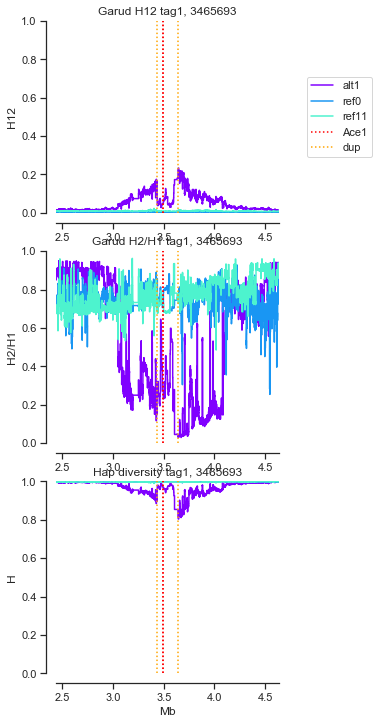

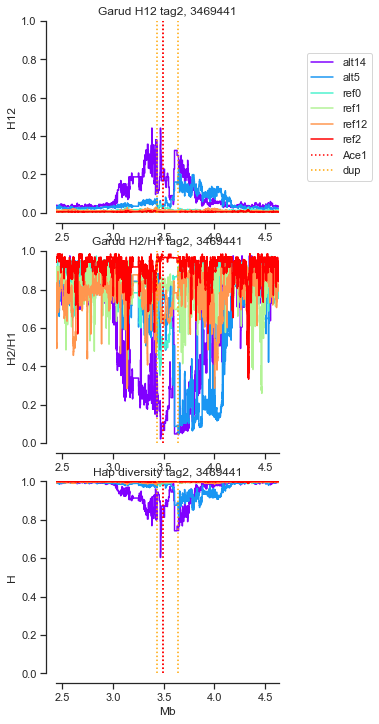

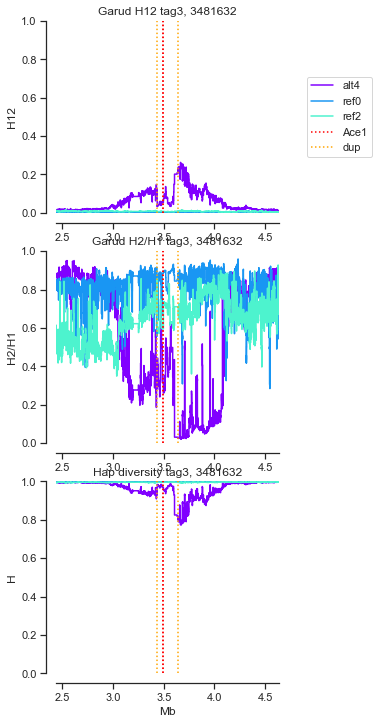

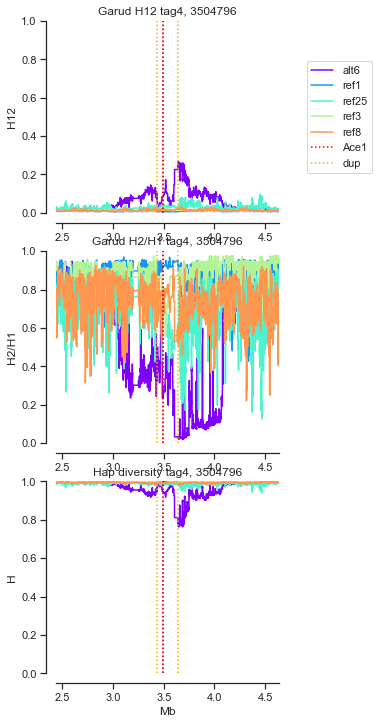

In [18]:
# parameters
block_len_hap = 500   # for the whole-genome view
step_len_hap  = 100   # for the whole-genome view
colors        = cm.rainbow(np.linspace(0, 1, 6))
fbp_hap_extra = 1e6
flank_peak    = 1e6

# variants positions
print("Positions...")
clu_varbool    = np.logical_and(hapvars_seg["POS"] >= ace_dups-flank_peak, hapvars_seg["POS"] < ace_dupe+flank_peak)
clu_pos_wib    = allel.moving_statistic(hapvars_seg["POS"].subset(sel0=clu_varbool), statistic=lambda v: v[0], size=block_len_hap,step=step_len_hap)

# open pdf
pdf = PdfPages("%s/%s_%s.sel_garudH_dup.pdf" % (outdir,outcode,l_nom))

for h,geni in enumerate(genilist):
    
    geni_bool = hapvars_seg["POS"][:] == geni
    geni_dkey = str(geni)

    fig = plt.figure(figsize=(4,12))

    # create hap dictionary: similar to pop dict, but for associations hap-cluster
    popdicthap_clui = dict()
    # first, for alternate allele clusters:
    is_clu_alt   = geni_components_id_dati[geni_dkey]["allele"] == 1
    is_clu_large_clust = np.unique(geni_components_id_dati[geni_dkey]["hap_distinct"][is_clu_alt],return_counts=True)[0]
    is_clu_large_sizes = np.unique(geni_components_id_dati[geni_dkey]["hap_distinct"][is_clu_alt],return_counts=True)[1]
    for i,clvi in enumerate(is_clu_large_clust):
        if is_clu_large_sizes[i] > 20 :
            is_clu_large = geni_components_id_dati[geni_dkey]["hap_distinct"] == clvi
            popdicthap_clui["alt" + str(clvi)] = np.where(np.logical_and(is_clu_alt, is_clu_large))[0]
    # then, for reference allele clusters
    is_clu_ref = geni_components_id_dati[geni_dkey]["allele"] == 0
    is_clu_large_clust = np.unique(geni_components_id_dati[geni_dkey]["hap_distinct"][is_clu_ref],return_counts=True)[0]
    is_clu_large_sizes = np.unique(geni_components_id_dati[geni_dkey]["hap_distinct"][is_clu_ref],return_counts=True)[1]
    for i,clvi in enumerate(is_clu_large_clust):
        if is_clu_large_sizes[i] > 100 :
            is_clu_large = geni_components_id_dati[geni_dkey]["hap_distinct"] == clvi
            popdicthap_clui["ref" + str(clvi)] = np.where(np.logical_and(is_clu_ref, is_clu_large))[0]

    # report
    print("****",geniname[h],geni,"| Garud for clusters in alleles ref and alt")

    # whole chromosome: frame
    ax1 = plt.subplot(3, 1, 1)
    sns.despine(ax=ax1,offset=10)
    ax1.set_title("Garud H12 %s, %i" % (geniname[h],geni))
    ax1.set_xlim((ace_dups-flank_peak)/1e6,(ace_dupe+flank_peak)/1e6)
    ax1.set_ylim(0,1)
    ax1.set_ylabel("H12")

    # garud h2h1
    ax2 = plt.subplot(3, 1, 2)
    sns.despine(ax=ax2,offset=10)
    ax2.set_title("Garud H2/H1 %s, %i" % (geniname[h],geni))
    ax2.set_xlim((ace_dups-flank_peak)/1e6,(ace_dupe+flank_peak)/1e6)
    ax2.set_ylim(0,1)
    ax2.set_ylabel("H2/H1")

    # hap div
    ax3 = plt.subplot(3, 1, 3)
    sns.despine(ax=ax3,offset=10)
    ax3.set_title("Hap diversity %s, %i" % (geniname[h],geni))
    ax3.set_xlim((ace_dups-flank_peak)/1e6,(ace_dupe+flank_peak)/1e6)
    ax3.set_ylim(0,1)
    ax3.set_xlabel("Mb")
    ax3.set_ylabel("H")

    sorted_keys = sorted(popdicthap_clui.keys(), key=lambda x:x.lower())

    for i,clui in enumerate(sorted_keys):

        # which variants include in the cluster-wise analysis of selection?
        clu_sambool = np.isin(range(0,haploty_seg.n_haplotypes),test_elements=popdicthap_clui[clui])

        # selection: Garud's H
        print("Garud H %s - chr..." % clui)
        clu_gah_wib = allel.moving_garud_h(haploty_seg.subset(sel0=clu_varbool, 
                                                              sel1=popdicthap_clui[clui]), size=block_len_hap, step=step_len_hap)
        plt.subplot(3, 1, 1)
        plt.step(clu_pos_wib/1e6, clu_gah_wib[1], color=colors[i], label=clui)
        plt.subplot(3, 1, 2)
        plt.step(clu_pos_wib/1e6, clu_gah_wib[3], color=colors[i])

        # haplotype diversity
        print("Hap div %s - chr..." % clui)
        clu_hdi_wib = allel.moving_haplotype_diversity(haploty_seg.subset(sel0=clu_varbool,
                                                                          sel1=popdicthap_clui[clui]), size=block_len_hap, step=step_len_hap)
        plt.subplot(3, 1, 3)
        plt.step(clu_pos_wib/1e6, clu_hdi_wib, color=colors[i])

    plt.subplot(3, 1, 1)
    plt.axvline(ace_start/1e6, color='red',linestyle=":",label="Ace1")
    plt.axvline(ace_end/1e6, color='red',linestyle=":",label="")
    plt.axvline(ace_dups/1e6, color='orange',linestyle=":",label="dup")
    plt.axvline(ace_dupe/1e6, color='orange',linestyle=":",label="")
    ax1.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

    plt.subplot(3, 1, 2)
    plt.axvline(ace_start/1e6, color='red',linestyle=":",label="Ace1")
    plt.axvline(ace_end/1e6, color='red',linestyle=":",label="")
    plt.axvline(ace_dups/1e6, color='orange',linestyle=":",label="dup")
    plt.axvline(ace_dupe/1e6, color='orange',linestyle=":",label="")

    plt.subplot(3, 1, 3)
    plt.axvline(ace_start/1e6, color='red',linestyle=":",label="Ace1")
    plt.axvline(ace_end/1e6, color='red',linestyle=":",label="")
    plt.axvline(ace_dups/1e6, color='orange',linestyle=":",label="dup")
    plt.axvline(ace_dupe/1e6, color='orange',linestyle=":",label="")

    pdf.savefig(fig,bbox_inches='tight')

pdf.close()

Selection statistics before duplication start:

In [19]:
for h,geni in enumerate(genilist):
    
    geni_dkey = str(geni)
    # create hap dictionary: similar to pop dict, but for associations hap-cluster
    popdicthap_clui = dict()
    # first, for alternate allele clusters:
    is_clu_alt   = geni_components_id_dati[geni_dkey]["allele"] == 1
    is_clu_large_clust = np.unique(geni_components_id_dati[geni_dkey]["hap_distinct"][is_clu_alt],return_counts=True)[0]
    is_clu_large_sizes = np.unique(geni_components_id_dati[geni_dkey]["hap_distinct"][is_clu_alt],return_counts=True)[1]
    for i,clvi in enumerate(is_clu_large_clust):
        if is_clu_large_sizes[i] > 20 :
            is_clu_large = geni_components_id_dati[geni_dkey]["hap_distinct"] == clvi
            popdicthap_clui["alt" + str(clvi)] = np.where(np.logical_and(is_clu_alt, is_clu_large))[0]
    # then, for reference allele clusters
    is_clu_ref = geni_components_id_dati[geni_dkey]["allele"] == 0
    is_clu_large_clust = np.unique(geni_components_id_dati[geni_dkey]["hap_distinct"][is_clu_ref],return_counts=True)[0]
    is_clu_large_sizes = np.unique(geni_components_id_dati[geni_dkey]["hap_distinct"][is_clu_ref],return_counts=True)[1]
    for i,clvi in enumerate(is_clu_large_clust):
        if is_clu_large_sizes[i] > 100 :
            is_clu_large = geni_components_id_dati[geni_dkey]["hap_distinct"] == clvi
            popdicthap_clui["ref" + str(clvi)] = np.where(np.logical_and(is_clu_ref, is_clu_large))[0]

    # report
    print("****",geniname[h],geni,"| Garud for Ace1 clusters in alleles ref and alt")
    clu_varbool = np.logical_and(hapvars_seg["POS"] >= ace_dups-5000, hapvars_seg["POS"] < ace_dups)
    
    sorted_keys = sorted(popdicthap_clui.keys(), key=lambda x:x.lower())

    for _,clui in enumerate(sorted_keys):

        print(clui)
        
        # haplotype diversity
        j_run = len(popdicthap_clui[clui])
        j_hdi = np.zeros(shape=j_run)
        for i in range(j_run):
            j_sel1   = popdicthap_clui[clui][0:i].tolist() + popdicthap_clui[clui][i+1:j_run].tolist()
            j_hdi[i] = allel.haplotype_diversity(haploty_seg.subset(sel0=clu_varbool, sel1=j_sel1))
        j_av,j_se,j_cl,j_cu,j_nu = mean_se_ci_report(j_hdi)
        print("Hap div %s \t = %.6f +/- %.6f SE, %.6f-%.6f CI95, n=%i" % (clui, j_av, j_se, j_cl, j_cu, j_nu))

        # Garud H12
        j_run  = len(popdicthap_clui[clui])
        j_h12  = np.zeros(shape=j_run)
        j_h2h1 = np.zeros(shape=j_run)
        for i in range(j_run):
            j_sel1    = popdicthap_clui[clui][0:i].tolist() + popdicthap_clui[clui][i+1:j_run].tolist()
            j_hstat   = allel.garud_h(haploty_seg.subset(sel0=clu_varbool, sel1=j_sel1))
            j_h12[i]  = j_hstat[1]
            j_h2h1[i] = j_hstat[3]
        j_av,j_se,j_cl,j_cu,j_nu = mean_se_ci_report(j_h12)
        print("H12 %s     \t = %.6f +/- %.6f SE, %.6f-%.6f CI95, n=%i" % (clui, j_av, j_se, j_cl, j_cu, j_nu))
        j_av,j_se,j_cl,j_cu,j_nu = mean_se_ci_report(j_h2h1)
        print("H2H1 %s    \t = %.6f +/- %.6f SE, %.6f-%.6f CI95, n=%i" % (clui, j_av, j_se, j_cl, j_cu, j_nu))    


**** tag1 3465693 | Garud for Ace1 clusters in alleles ref and alt
alt1
Hap div alt1 	 = 0.915789 +/- 0.002090 SE, 0.914299-0.919112 CI95, n=115
H12 alt1     	 = 0.135794 +/- 0.002912 SE, 0.131887-0.138042 CI95, n=115
H2H1 alt1    	 = 0.160537 +/- 0.005901 SE, 0.148087-0.168685 CI95, n=115
ref0
Hap div ref0 	 = 0.997725 +/- 0.000007 SE, 0.997722-0.997757 CI95, n=1457
H12 ref0     	 = 0.004034 +/- 0.000013 SE, 0.003976-0.004039 CI95, n=1457
H2H1 ref0    	 = 0.770208 +/- 0.001570 SE, 0.768812-0.779478 CI95, n=1457
ref11
Hap div ref11 	 = 0.996548 +/- 0.000095 SE, 0.996513-0.996924 CI95, n=199
H12 ref11     	 = 0.011212 +/- 0.000187 SE, 0.010560-0.011274 CI95, n=199
H2H1 ref11    	 = 0.758875 +/- 0.008788 SE, 0.750000-0.798742 CI95, n=199
**** tag2 3469441 | Garud for Ace1 clusters in alleles ref and alt
alt14
Hap div alt14 	 = 0.858537 +/- 0.008278 SE, 0.851282-0.869231 CI95, n=41
H12 alt14     	 = 0.252104 +/- 0.011815 SE, 0.240000-0.263750 CI95, n=41
H2H1 alt14    	 = 0.178192 +/- 0.01

Selection statistics after duplication ends:

In [20]:
for h,geni in enumerate(genilist):
    
    geni_dkey = str(geni)
    # create hap dictionary: similar to pop dict, but for associations hap-cluster
    popdicthap_clui = dict()
    # first, for alternate allele clusters:
    is_clu_alt   = geni_components_id_dati[geni_dkey]["allele"] == 1
    is_clu_large_clust = np.unique(geni_components_id_dati[geni_dkey]["hap_distinct"][is_clu_alt],return_counts=True)[0]
    is_clu_large_sizes = np.unique(geni_components_id_dati[geni_dkey]["hap_distinct"][is_clu_alt],return_counts=True)[1]
    for i,clvi in enumerate(is_clu_large_clust):
        if is_clu_large_sizes[i] > 20 :
            is_clu_large = geni_components_id_dati[geni_dkey]["hap_distinct"] == clvi
            popdicthap_clui["alt" + str(clvi)] = np.where(np.logical_and(is_clu_alt, is_clu_large))[0]
    # then, for reference allele clusters
    is_clu_ref = geni_components_id_dati[geni_dkey]["allele"] == 0
    is_clu_large_clust = np.unique(geni_components_id_dati[geni_dkey]["hap_distinct"][is_clu_ref],return_counts=True)[0]
    is_clu_large_sizes = np.unique(geni_components_id_dati[geni_dkey]["hap_distinct"][is_clu_ref],return_counts=True)[1]
    for i,clvi in enumerate(is_clu_large_clust):
        if is_clu_large_sizes[i] > 100 :
            is_clu_large = geni_components_id_dati[geni_dkey]["hap_distinct"] == clvi
            popdicthap_clui["ref" + str(clvi)] = np.where(np.logical_and(is_clu_ref, is_clu_large))[0]


    # report
    print("****",geniname[h],geni,"| Garud for Ace1 clusters in alleles ref and alt")
    clu_varbool = np.logical_and(hapvars_seg["POS"] >= ace_dupe, hapvars_seg["POS"] < ace_dupe+5000)
    
    sorted_keys = sorted(popdicthap_clui.keys(), key=lambda x:x.lower())

    for _,clui in enumerate(sorted_keys):

        print(clui)
        
        # haplotype diversity
        j_run = len(popdicthap_clui[clui])
        j_hdi = np.zeros(shape=j_run)
        for i in range(j_run):
            j_sel1   = popdicthap_clui[clui][0:i].tolist() + popdicthap_clui[clui][i+1:j_run].tolist()
            j_hdi[i] = allel.haplotype_diversity(haploty_seg.subset(sel0=clu_varbool, sel1=j_sel1))
        j_av,j_se,j_cl,j_cu,j_nu = mean_se_ci_report(j_hdi)
        print("Hap div %s \t = %.6f +/- %.6f SE, %.6f-%.6f CI95, n=%i" % (clui, j_av, j_se, j_cl, j_cu, j_nu))

        # Garud H12
        j_run  = len(popdicthap_clui[clui])
        j_h12  = np.zeros(shape=j_run)
        j_h2h1 = np.zeros(shape=j_run)
        for i in range(j_run):
            j_sel1    = popdicthap_clui[clui][0:i].tolist() + popdicthap_clui[clui][i+1:j_run].tolist()
            j_hstat   = allel.garud_h(haploty_seg.subset(sel0=clu_varbool, sel1=j_sel1))
            j_h12[i]  = j_hstat[1]
            j_h2h1[i] = j_hstat[3]
        j_av,j_se,j_cl,j_cu,j_nu = mean_se_ci_report(j_h12)
        print("H12 %s     \t = %.6f +/- %.6f SE, %.6f-%.6f CI95, n=%i" % (clui, j_av, j_se, j_cl, j_cu, j_nu))
        j_av,j_se,j_cl,j_cu,j_nu = mean_se_ci_report(j_h2h1)
        print("H2H1 %s    \t = %.6f +/- %.6f SE, %.6f-%.6f CI95, n=%i" % (clui, j_av, j_se, j_cl, j_cu, j_nu))    


**** tag1 3465693 | Garud for Ace1 clusters in alleles ref and alt
alt1
Hap div alt1 	 = 0.853699 +/- 0.003219 SE, 0.851110-0.857786 CI95, n=115
H12 alt1     	 = 0.180403 +/- 0.003551 SE, 0.176208-0.183441 CI95, n=115
H2H1 alt1    	 = 0.048027 +/- 0.001552 SE, 0.044423-0.049846 CI95, n=115
ref0
Hap div ref0 	 = 0.997857 +/- 0.000008 SE, 0.997854-0.997889 CI95, n=1457
H12 ref0     	 = 0.004081 +/- 0.000015 SE, 0.004018-0.004086 CI95, n=1457
H2H1 ref0    	 = 0.759491 +/- 0.001641 SE, 0.758043-0.769062 CI95, n=1457
ref11
Hap div ref11 	 = 0.997005 +/- 0.000091 SE, 0.996975-0.997385 CI95, n=199
H12 ref11     	 = 0.010303 +/- 0.000169 SE, 0.009693-0.010356 CI95, n=199
H2H1 ref11    	 = 0.745234 +/- 0.009099 SE, 0.740216-0.786667 CI95, n=199
**** tag2 3469441 | Garud for Ace1 clusters in alleles ref and alt
alt14
Hap div alt14 	 = 0.767073 +/- 0.012118 SE, 0.755128-0.779487 CI95, n=41
H12 alt14     	 = 0.299665 +/- 0.013090 SE, 0.287500-0.313750 CI95, n=41
H2H1 alt14    	 = 0.055699 +/- 0.00